In [1]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [2]:
data_dir = r'D:\Pictures\Samples\Robusta'

In [3]:
class_labels = ['Cercospora', 'Cercospora and Leaf Rust', 'Coffee Wilt', 'Healthy', 'Leaf Rust', 'Yellow Leaf Cercospora']

In [4]:
# Image pre-process/Image augmentation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0]*len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


In [6]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)

In [7]:
train_size = int(0.8 * len(dataset))  
val_size = len(dataset) - train_size  
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) 

In [8]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 726
Length of validation dataset: 182


In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Nicko/.cache\torch\hub\v0.10.0.zip
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Nicko/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 37.0MB/s]


In [12]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [13]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [14]:
# Create the CNN model
model = resnet


In [15]:
# Check for available GPUs
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    print("GPU not available, using CPU")
    device = torch.device("cpu")


Using GPU: NVIDIA GeForce GTX 1650 Ti


In [16]:
# Move the model to the GPU
model = model.to(device)


In [17]:
total_samples = 554 + 40 + 53 + 160 + 48 + 95
class_weights = [total_samples / x for x in [554, 40, 53, 160, 48, 95]]
weights = torch.tensor(class_weights).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/32
----------
train Loss: 1.0422 Acc: 0.0565
val Loss: 0.7823 Acc: 0.2582
Epoch 2/32
----------
train Loss: 0.6980 Acc: 0.3678
val Loss: 0.6050 Acc: 0.2363
Epoch 3/32
----------
train Loss: 0.5775 Acc: 0.4187
val Loss: 0.5022 Acc: 0.4890
Epoch 4/32
----------
train Loss: 0.4948 Acc: 0.5344
val Loss: 0.4439 Acc: 0.5934
Epoch 5/32
----------
train Loss: 0.4749 Acc: 0.5372
val Loss: 0.4071 Acc: 0.6703
Epoch 6/32
----------
train Loss: 0.4444 Acc: 0.5744
val Loss: 0.3336 Acc: 0.7473
Epoch 7/32
----------
train Loss: 0.3831 Acc: 0.6281
val Loss: 0.3476 Acc: 0.7967
Epoch 8/32
----------
train Loss: 0.3594 Acc: 0.6832
val Loss: 0.3383 Acc: 0.6978
Epoch 9/32
----------
train Loss: 0.3496 Acc: 0.6501
val Loss: 0.3181 Acc: 0.6758
Epoch 10/32
----------
train Loss: 0.3257 Acc: 0.7039
val Loss: 0.2838 Acc: 0.7363
Epoch 11/32
----------
train Loss: 0.3228 Acc: 0.6832
val Loss: 0.2879 Acc: 0.7527
Epoch 12/32
----------
train Loss: 0.3076 Acc: 0.7011
val Loss: 0.2865 Acc: 0.6923
Epoch 13/32
-

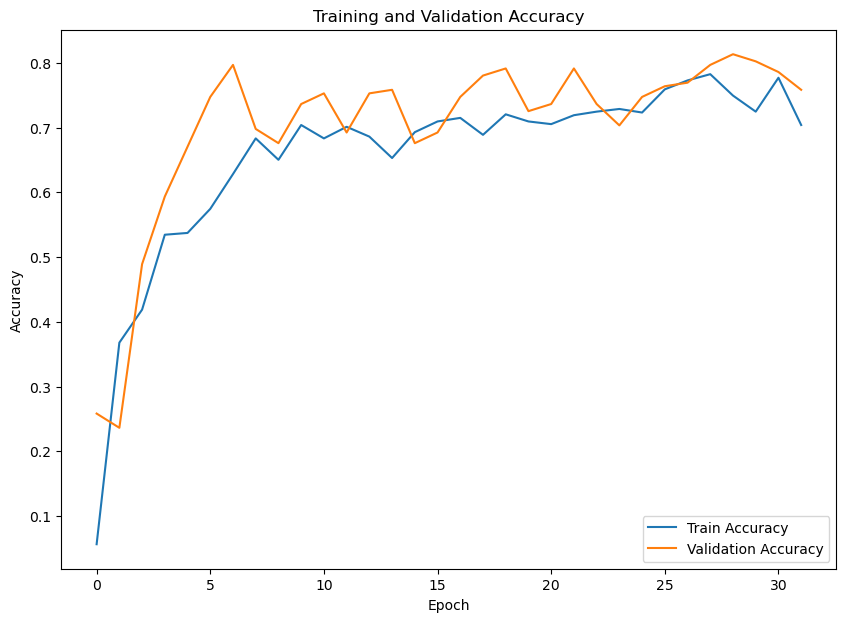

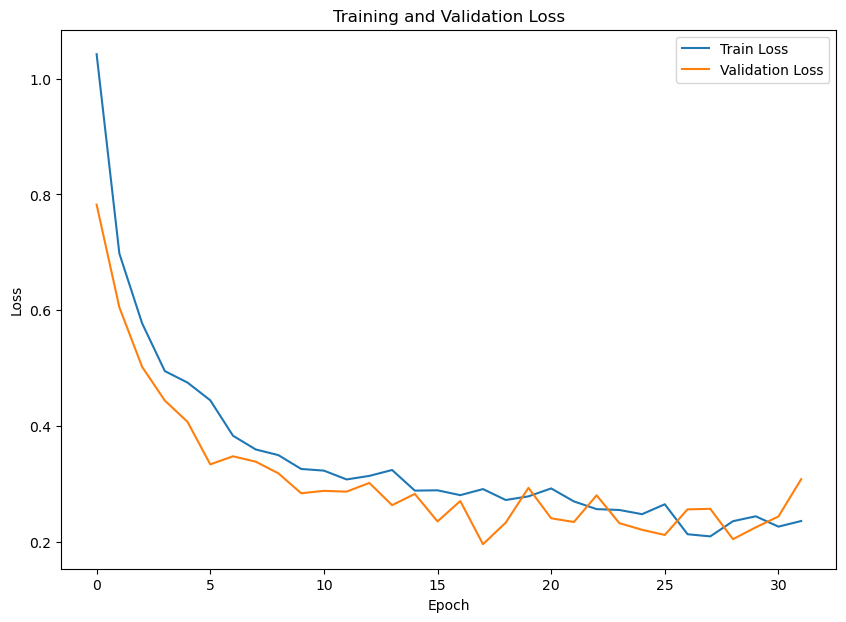

In [18]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists for saving history
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float() 

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Get the probabilities from the outputs
                    probs = torch.sigmoid(outputs)
                    # Apply a threshold of 0.5
                    preds = probs > 0.5
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate the number of correct predictions
                corrects = (preds == labels.byte()).all(1).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

model = train_model(model, criterion, optimizer, num_epochs=32)


In [55]:
def predict_image(image_path, model):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return class_labels[predicted]

image_path = "Cercospora.jpg"  
print("Predicted Class: ", predict_image(image_path, model))

Predicted Class:  Cercospora
